# 20220405-offsetbit-sweep
## Analysis ofthe offset bit sweep for Ray Tune

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('~/GitHub/voyager/offsetbit_sweep_results.csv')
df

,Unnamed: 0,run,val_loss,val_acc,val_page_acc,val_offset_acc,done,offset_bits
0,0,soplex_66B,0.369485,74.108475,87.014305,78.166690,True,6
1,1,soplex_66B,0.173058,77.501660,86.474860,83.418090,True,5
2,2,soplex_66B,0.308560,78.756966,95.968410,79.520680,True,12
3,3,soplex_66B,0.216186,77.496020,86.922330,82.967650,True,5
4,4,soplex_66B,0.395480,70.070430,88.967170,72.061750,True,8
...,...,...,...,...,...,...,...,...
78,6,mcf_46B,9.733133,22.139048,33.817932,36.719685,True,10
79,7,mcf_46B,10.130086,34.741760,47.668940,45.749596,True,12
80,8,mcf_46B,10.157827,27.264130,40.168247,40.290184,True,11
81,9,mcf_46B,8.323650,25.464138,30.086056,47.502500,True,6


# Trace plots

Validation accuracy of:
- Baseline (6 bits)
- Best (? bits)
- Worst (? bits)

TODO: Validation page / offset accuracy

In [75]:
def plot_run_performance(df, metric='val_acc',
                         baseline_col='offset_bits', 
                         baseline_val=6,
                         dpi=160):
    fig, ax = plt.subplots(dpi=dpi)
    
    runs = []
    
    base_run_vals = []
    min_run_vals = []
    max_run_vals = []
    
    base_runs = []
    min_runs = []
    max_runs = []
    
    # Get values
    for run in df.run.unique():
        run_df = df[df.run == run][[baseline_col, metric]]
        run_df = run_df.groupby(baseline_col).max(metric).reset_index() # If we repeat runs of a config, get the best one.
        #print(run) # DEBUG
        #print(run_df) # DEBUG
        
        base_run = run_df[run_df[baseline_col] == baseline_val]
        min_run  = run_df[run_df[metric] == run_df[metric].min()]
        max_run  = run_df[run_df[metric] == run_df[metric].max()]
        
        # TODO - Turn this into a df and return (instead of printing)
        #        (see improvement table)
        #if len(base_run) > 0:
        #    print(f'{run:15} Base : {base_run[baseline_col].item():3} {base_run[metric].item()}')
        #print(f'{run:15} Max  : {max_run[baseline_col].item():3} {max_run[metric].item()}')
        #print(f'{run:15} Min  : {min_run[baseline_col].item():3} {min_run[metric].item()}')
        #print()
        
        runs.append(run.split('_')[0])
        base_runs.append(base_run[metric].item() if len(base_run) == 1 else np.nan)
        min_runs.append(min_run[metric].item())
        max_runs.append(max_run[metric].item())
        base_run_vals.append(base_run[baseline_col].item() if len(base_run) == 1 else np.nan)
        min_run_vals.append(min_run[baseline_col].item())
        max_run_vals.append(max_run[baseline_col].item())
        
    # Plot bars
    ax.bar(np.arange(0, len(runs))*5, min_runs, label='min')
    ax.bar(np.arange(0, len(runs))*5 + 1, base_runs, label='baseline')
    ax.bar(np.arange(0, len(runs))*5 + 2, max_runs, label='max')
    
    # Annotate bars
    for i in range(len(runs)):
        ax.annotate(
            min_run_vals[i],
            (i*5, 0),
            ha='center', va='bottom', color='white',
            fontsize=6,
        )
        ax.annotate(
            base_run_vals[i],
            (i*5 + 1, 0),
            ha='center', va='bottom', color='white',
            fontsize=6,
        )
        ax.annotate(
            max_run_vals[i],
            (i*5 + 2, 0),
            ha='center', va='bottom', color='white',
            fontsize=6,
        )

    
    # Plot ticks / labels / legend
    ax.set_xlabel('Trace')
    ax.set_xticks(np.arange(0, len(runs))*5 + 1)
    ax.set_xticklabels(runs, rotation=45)
    ax.set_ylabel(metric)
    ax.set_ylim(ymin=0, ymax=100) # TODO: Make adjustable
    
    fig.suptitle(f'{metric} on {baseline_col}')
    fig.tight_layout()
    fig.legend(bbox_to_anchor=(1, 1))

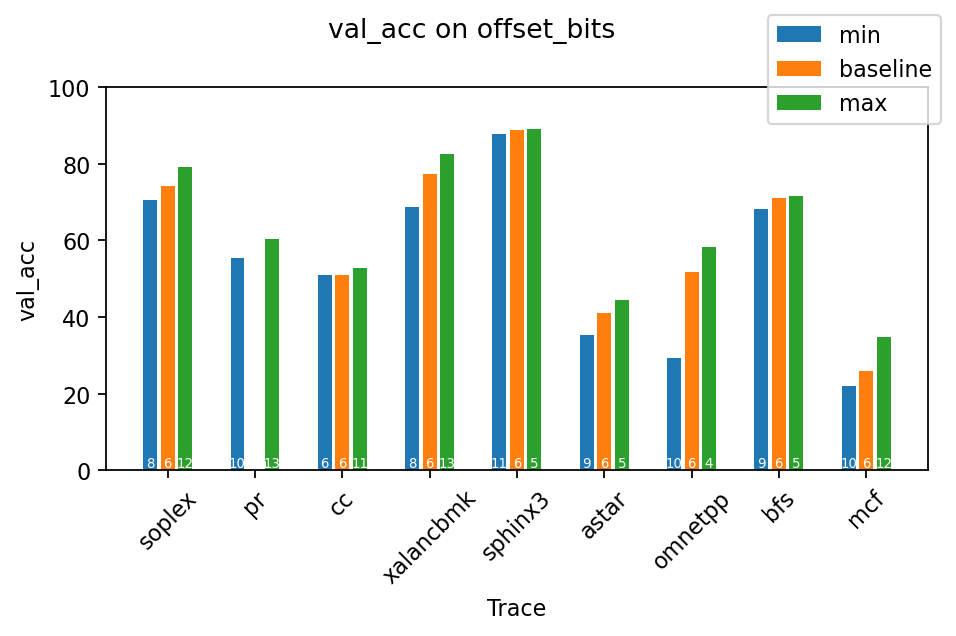

In [74]:
plot_run_performance(df, metric='val_acc')

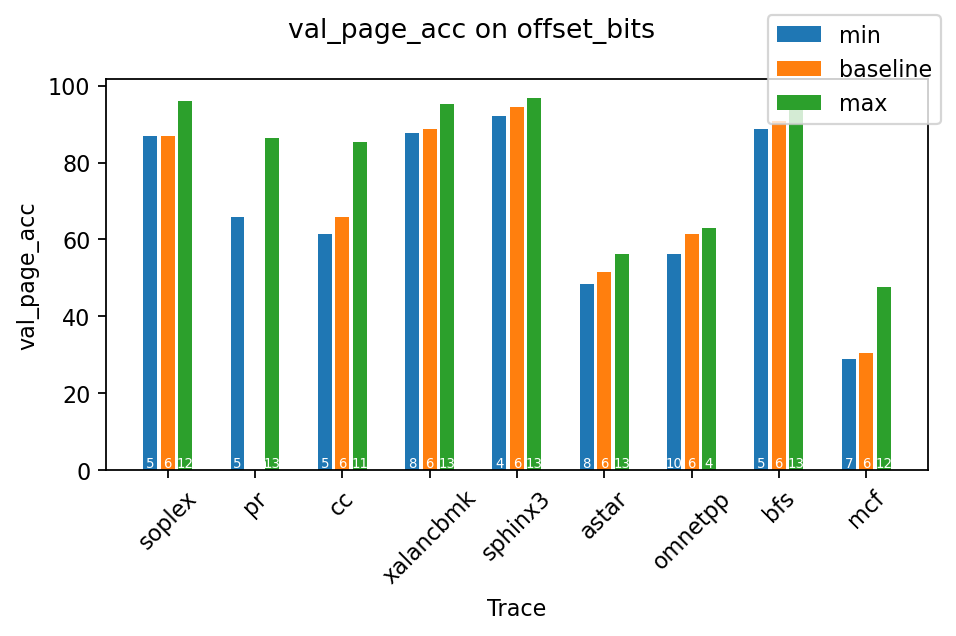

In [71]:
plot_run_performance(df, metric='val_page_acc')

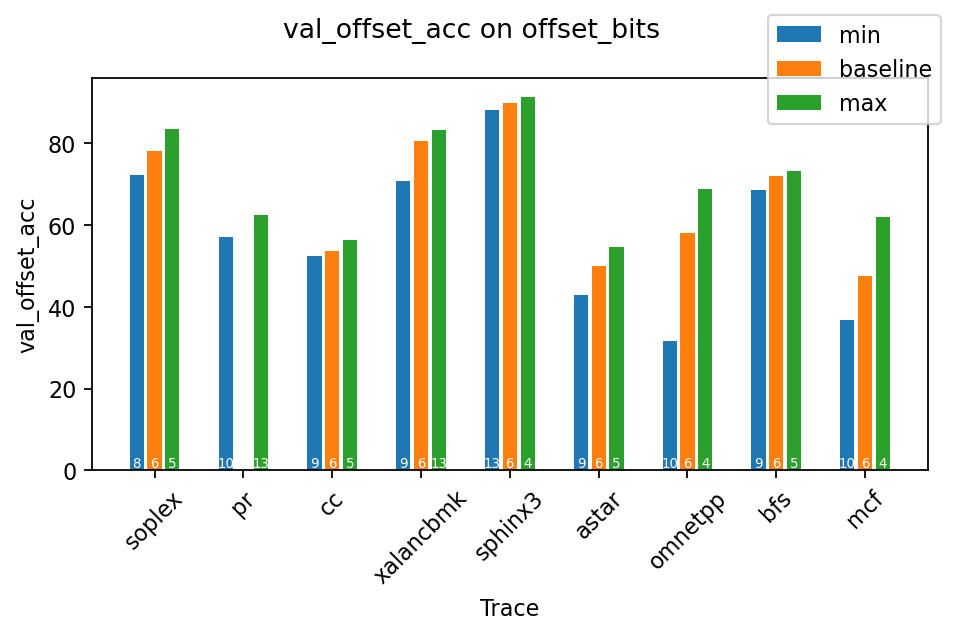

In [72]:
plot_run_performance(df, metric='val_offset_acc')

# Improvement table
How much did we gain from tuning?
- `max - baseline`

In [65]:
def difference_df(df, metric='val_acc',
                  baseline_col='offset_bits', 
                  baseline_val=6):
    df = df[['run', baseline_col, metric]]

    
    base_val = df[df[baseline_col] == baseline_val].groupby('run').max()
    max_val = df.groupby('run').max(metric)
    
    base_val[f'{baseline_col}_max'] = max_val[baseline_col]
    base_val[f'{metric}_max'] = max_val[metric]
    base_val[f'{metric}_improvement'] = max_val[metric] - base_val[metric]
   

    base_val.rename(columns = {
        f'{baseline_col}': f'{baseline_col}_base',
        f'{metric}': f'{metric}_base'
    }, inplace=True)
    
    return base_val

In [66]:
difference_df(df, metric='val_acc')

,offset_bits_base,val_acc_base,offset_bits_max,val_acc_max,val_acc_improvement
run,,,,,
astar_313B,6,41.130848,13,44.439260,3.308412
bfs,6,71.038180,13,71.573630,0.535450
cc,6,50.984020,11,52.661590,1.677570
mcf_46B,6,25.871593,12,34.741760,8.870167
omnetpp_340B,6,51.623390,12,58.203922,6.580532
soplex_66B,6,74.108475,12,79.071594,4.963119
sphinx3_2520B,6,88.654106,13,88.961845,0.307739
xalancbmk_99B,6,77.225820,13,82.639760,5.413940


In [67]:
difference_df(df, metric='val_page_acc')

,offset_bits_base,val_page_acc_base,offset_bits_max,val_page_acc_max,val_page_acc_improvement
run,,,,,
astar_313B,6,51.612408,13,56.256400,4.643992
bfs,6,90.752920,13,95.166310,4.413390
cc,6,65.917990,11,85.317635,19.399645
mcf_46B,6,30.626743,12,47.668940,17.042197
omnetpp_340B,6,61.361374,12,62.952404,1.591030
soplex_66B,6,87.014305,12,96.022730,9.008425
sphinx3_2520B,6,94.448480,13,96.780620,2.332140
xalancbmk_99B,6,88.689800,13,95.203600,6.513800


In [68]:
difference_df(df, metric='val_offset_acc')

,offset_bits_base,val_offset_acc_base,offset_bits_max,val_offset_acc_max,val_offset_acc_improvement
run,,,,,
astar_313B,6,49.883663,13,54.570972,4.687309
bfs,6,71.962000,13,73.086810,1.124810
cc,6,53.591730,11,56.416363,2.824633
mcf_46B,6,47.502500,12,61.858105,14.355605
omnetpp_340B,6,58.072495,12,68.645490,10.572995
soplex_66B,6,78.166690,12,83.418090,5.251400
sphinx3_2520B,6,89.690400,13,91.322260,1.631860
xalancbmk_99B,6,80.503310,13,83.216960,2.713650
